In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'

# 7 Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# 8 Outputs
teff = []
luminosity = []
dnufit = []
FeH = []
G_GAIA = []
massfin = []
numax = []
MeH = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = list(tracks.keys())
    random.seed(1)
    random.shuffle(track_names)

    # Choose a subset of tracks to process
    num_tracks = 1000  # Set the number of tracks to process
    selected_tracks = track_names[:num_tracks]

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        
        # Inputs
        ages.append(track['age'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

        # Outputs
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        dnufit.append(track['dnufit'][:])
        FeH.append(track['FeH'][:])
        G_GAIA.append(track['G_GAIA'][:])
        massfin.append(track['massfin'][:])
        numax.append(track['numax'][:])
        MeH.append(track['MeH'][:])

# Convert lists to numpy arrays and concatenate them (make one big list)

epsilon = 1e-10

# Features requiring log10 transformation
log10_vars_inputs = [ages, massini, alphamlt, eta, yini]

# Transform log10 variables
log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]

# Concatenate all inputs, including raw `fehini` and `yini`
inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), 
                                               np.concatenate(alphafe).reshape(-1, 1)])

# Features requiring log10 transformation (strictly positive outputs)
log10_vars_outputs = [teff, luminosity, dnufit, massfin, numax]

# Transform log10 variables
log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]

# Combine transformed log10 outputs with raw FeH and MeH
# FeH and MeH are not transformed, concatenated directly
outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1), 
                                                 np.concatenate(MeH).reshape(-1, 1),
                                                 np.concatenate(G_GAIA).reshape(-1, 1)])



In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  


In [4]:
# Define the neural network
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        
        # Input layer -> First hidden layer
        self.dense1 = nn.Linear(7, 128)  # Wider first layer
        self.dense2 = nn.Linear(128, 128)
        self.dense3 = nn.Linear(128, 128)
        self.dense4 = nn.Linear(128, 64)  
        self.dense5 = nn.Linear(64, 64)        
        self.dense6 = nn.Linear(64, 8)  # Assuming 8 output features
        
    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = torch.relu(self.dense3(x))
        x = torch.relu(self.dense4(x))
        x = torch.relu(self.dense5(x))
        x = self.dense6(x)  
        return x

    
# Instantiate the model
model = GarstecNet()

# Load the checkpoint
checkpoint_path = r'C:\Users\kiena\Downloads\best_model_v6_3.pth'
checkpoint = torch.load(checkpoint_path)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully.")

Model loaded successfully.


C:\Users\kiena\AppData\Local\Temp\ipykernel_11520\3325559559.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [5]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = scaler_y.inverse_transform(predictions.numpy())
    y_test_actual = scaler_y.inverse_transform(y_test_tensor.numpy())

    # Calculate evaluation metrics
    r2 = r2_score(y_test_actual, predictions)
    mae = mean_absolute_error(y_test_actual, predictions)

    print(f'R^2 Score: {r2:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')

R^2 Score: 0.1609
Mean Absolute Error: 0.2285


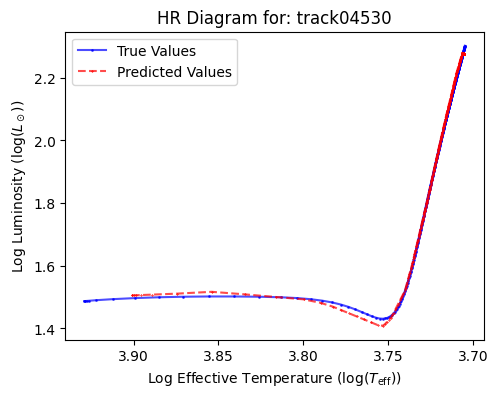

In [63]:
# Select random track from the same 10000 that we trained the NN on
#specific_track_name = 'track07918'
specific_track_name = selected_tracks[random.randint(0, len(selected_tracks) - 1)]  

# Retrieve all required inputs for the specific track
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    ages = specific_track['age'][:].reshape(-1, 1)
    massini = specific_track['massini'][:].reshape(-1, 1)
    fehini = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini = specific_track['yini'][:].reshape(-1, 1)
    eta = specific_track['eta'][:].reshape(-1, 1)
    alphafe = specific_track['alphaFe'][:].reshape(-1, 1)

    # Combine features into a single array
    all_features = np.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

    # Retrieve actual values for plotting
    teff_specific = specific_track['Teff'][:]
    luminosity_specific = specific_track['LPhot'][:]

# Combine inputs and apply log10 transformations where required
epsilon = 1e-10
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]
log10_transformed_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_vars_inputs]

# Combine log-transformed inputs with raw `fehini` and `yini`
all_features = np.hstack(log10_transformed_inputs + [fehini, yini])

# Scale the input features
all_features_scaled = scaler_X.transform(all_features)

# Convert scaled inputs to PyTorch tensor
all_features_tensor = torch.FloatTensor(all_features_scaled)

# Put the model in evaluation mode and make predictions
model.eval()
with torch.no_grad():
    predictions_specific = model(all_features_tensor).numpy()
    predictions_specific = scaler_y.inverse_transform(predictions_specific)

# Extract predicted `Teff` and `Luminosity`
predicted_teff = 10**predictions_specific[:, 0]  # Inverse log10 transformation
predicted_luminosity = 10**predictions_specific[:, 1]

# Log-transform true values for plotting
log_actual_teff = np.log10(teff_specific)
log_actual_luminosity = np.log10(luminosity_specific)

# Log-transform predicted values for plotting
log_predicted_teff = np.log10(predicted_teff)
log_predicted_luminosity = np.log10(predicted_luminosity)

# Plot HR Diagram for the selected track
plt.figure(figsize=(5.4, 4))  # Slightly less than half-width of A4 landscape
plt.plot(log_actual_teff, log_actual_luminosity, label='True Values', color='blue', marker='o', markersize=1, linestyle='-', alpha=0.7)
plt.plot(log_predicted_teff, log_predicted_luminosity, label='Predicted Values', color='red', marker='x', markersize=1, linestyle='--', alpha=0.7)
plt.gca().invert_xaxis()  # Effective temperature is plotted in reverse
plt.xlabel("Log Effective Temperature ($\log(T_\mathrm{eff})$)")
plt.ylabel("Log Luminosity ($\log(L_\odot)$)")
plt.title(f"HR Diagram for: {specific_track_name}")
plt.legend()
plt.show()





In [7]:
import unittest
import numpy as np
from sklearn.preprocessing import StandardScaler

class TestDataScaling(unittest.TestCase):

    def setUp(self):
        # Setup mock data for inputs and outputs
        self.epsilon = 1e-10
        self.raw_inputs = np.random.rand(100, 7) * 10 + 1  # Simulate positive random inputs
        self.raw_outputs = np.random.rand(100, 8) * 10 + 1  # Simulate positive random outputs

        # Log-transform inputs and outputs
        self.log_transformed_inputs = [np.log10(np.maximum(self.raw_inputs[:, i:i+1], self.epsilon)) for i in range(5)]
        self.log_transformed_outputs = [np.log10(np.maximum(self.raw_outputs[:, i:i+1], self.epsilon)) for i in range(5)]

        # Combine transformed inputs/outputs with raw ones where needed
        self.inputs = np.hstack(self.log_transformed_inputs + [self.raw_inputs[:, 5:7]])
        self.outputs = np.hstack(self.log_transformed_outputs + [self.raw_outputs[:, 5:8]])

        # Initialize scalers
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

        # Fit scalers
        self.scaled_inputs = self.scaler_X.fit_transform(self.inputs)
        self.scaled_outputs = self.scaler_y.fit_transform(self.outputs)

    def test_scaling_identity_inputs(self):
        # Test if descaling inputs restores the original data
        descaled_inputs = self.scaler_X.inverse_transform(self.scaled_inputs)
        np.testing.assert_almost_equal(descaled_inputs, self.inputs, decimal=6, 
                                       err_msg="Descaled inputs do not match original inputs")

    def test_scaling_identity_outputs(self):
        # Test if descaling outputs restores the original data
        descaled_outputs = self.scaler_y.inverse_transform(self.scaled_outputs)
        np.testing.assert_almost_equal(descaled_outputs, self.outputs, decimal=6, 
                                       err_msg="Descaled outputs do not match original outputs")

    def test_log_transform_identity(self):
        # Test if log and inverse-log operations restore the original data
        for i in range(5):  # Test only log-transformed variables
            reconstructed = 10 ** self.log_transformed_inputs[i]
            np.testing.assert_almost_equal(reconstructed, self.raw_inputs[:, i:i+1], decimal=6, 
                                           err_msg=f"Log and inverse-log failed for input column {i}")

    def test_predictions_scaling_consistency(self):
        # Simulate predictions and test scaling-descaling consistency
        mock_predictions = self.scaled_outputs  # Pretend scaled_outputs are NN outputs
        descaled_predictions = self.scaler_y.inverse_transform(mock_predictions)
        np.testing.assert_almost_equal(descaled_predictions, self.outputs, decimal=6, 
                                       err_msg="Predictions descaling does not match original outputs")

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


....
----------------------------------------------------------------------
Ran 4 tests in 0.017s

OK
